In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext.data import Field, LabelField, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True



In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
MAX_VOCAB_SIZE = 25000
TEXT = Field(tokenize = 'spacy',
             include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

train_data, valid_data, test_data = data.TabularDataset.splits(path = '/content/drive/My Drive/Colab Notebooks/NLP/', train = 'sst_train.csv',
                                        validation = 'val_few_unk.csv', test = 'test_few_unk.csv',
                                        format = 'csv', fields=[("idx", None), ("text", TEXT), ("label", LABEL)],
                                        skip_header = True)
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)
print("Unique tokens in TEXT vocabulary: " + str(len(TEXT.vocab)))
print("Unique tokens in LABEL vocabulary: " + str(len(LABEL.vocab)))
print("LABEL vocabulary frequency: " + str(LABEL.vocab.freqs))

print(vars(train_data.examples[0]))

print("Number of training examples: " + str(len(train_data)))
print("Number of validation examples: " + str(len(valid_data)))
print("Number of testing examples: " + str(len(test_data)))

Unique tokens in TEXT vocabulary: 13824
Unique tokens in LABEL vocabulary: 2
LABEL vocabulary frequency: Counter({'1': 3610, '0': 3310})
{'text': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', 's', 'new', 'conan', 'and', 'that', 'he', 's', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal'], 'label': '1'}
Number of training examples: 6920
Number of validation examples: 250
Number of testing examples: 250


In [23]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.text),
    device = device)

In [24]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, word_att_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.word_attention = nn.Linear(2 * hidden_dim, word_att_dim)
        self.word_context_vector = nn.Linear(word_att_dim, 1, bias=False)
        
        self.dropout = nn.Dropout(dropout)
       
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        att_w = self.word_attention(packed_output.data)  # (sum_words, att_size)
        att_w = torch.tanh(att_w)  # (sum_words, att_size)
        att_w = self.word_context_vector(att_w).squeeze(1)  # (sum_words)
        max_value = att_w.max()  # scalar, for numerical stability during exponent calculation
        att_w = torch.exp(att_w - max_value)  # (n_words)
        att_w, _ = nn.utils.rnn.pad_packed_sequence(nn.utils.rnn.PackedSequence(data=att_w,
                                                      batch_sizes=packed_output.batch_sizes,
                                                      sorted_indices=packed_output.sorted_indices,
                                                      unsorted_indices=packed_output.unsorted_indices),
                                       batch_first=True)  # (batch, max(words_per_sentence))

        word_alphas = att_w / torch.sum(att_w, dim=1, keepdim=True)
        doc, doc_len = nn.utils.rnn.pad_packed_sequence(packed_output,
                                           batch_first=True)  # (batch, max(words_per_sentence), 2 * word_rnn_size)
        
        doc = doc * word_alphas.unsqueeze(2)  # (batch, max(words_per_sentence), 2 * word_rnn_size)
        doc = doc.sum(dim=1)
        res = self.fc(doc)
            
        return res

In [25]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
ATT_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,
            ATT_DIM,
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has ' + str(count_parameters(model)) + ' trainable parameters')

The model has 3758849 trainable parameters


In [27]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.2512,  0.6499, -0.2465,  ...,  0.0659, -0.9114,  0.4129],
        [ 0.3050,  0.7940, -1.7121,  ...,  0.4031,  0.5243, -1.7234],
        [-0.1327, -0.8911,  0.2346,  ..., -0.1750, -0.1385,  0.6226]])

In [28]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.2512,  0.6499, -0.2465,  ...,  0.0659, -0.9114,  0.4129],
        [ 0.3050,  0.7940, -1.7121,  ...,  0.4031,  0.5243, -1.7234],
        [-0.1327, -0.8911,  0.2346,  ..., -0.1750, -0.1385,  0.6226]])


In [29]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [30]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [31]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [32]:
def f1_score(preds, y):
    """
    Returns f1_score per batch
    """
    
    rounded_preds = torch.round(torch.sigmoid(preds))
    tp = (rounded_preds == y).float().sum()
    tn = len((rounded_preds == y).float()) - tp
    fp = (rounded_preds != y).float().sum()
    fn = len((rounded_preds != y).float()) - fp
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [33]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        f1 = f1_score(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
            
            f1 = f1_score(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [35]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
N_EPOCHS = 5

best_valid_loss = float('inf')
train_a = []
val_a = []
test_a = []

print("Training with pre-trained word embeddings...")

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion)
    test_loss, test_acc, test_f1 = evaluate(model, test_iterator, criterion)

    train_a.append(train_acc)
    val_a.append(valid_acc)
    test_a.append(test_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print("Epoch: " + str(epoch+1) + " Epoch Time: " + str(epoch_mins) + "m " + str(epoch_secs) + "s")
    print("Train Loss: " + str(round(train_loss, 4)) + " Train Acc: " + str(round(train_acc * 100, 4)) + " Train F1: " + str(round(train_f1 * 100, 4)))
    print("Val. Loss : " + str(round(valid_loss, 4)) + " Val.  Acc: " + str(round(valid_acc * 100, 4)) + " Valid F1: " + str(round(valid_f1 * 100, 4)))
    print("Test Loss : " + str(round(test_loss, 4)) +  " Test Acc: " + str(round(test_acc * 100, 4)) +  " Train F1: " + str(round(test_f1 * 100, 4)))
    print("\n")

Training with pre-trained word embeddings...
Epoch: 1 Epoch Time: 1m 4s
Train Loss: 0.6013 Train Acc: 67.4025 Train F1: 57.1852
Val. Loss : 0.4596 Val.  Acc: 74.9327 Valid F1: 59.7994
Test Loss : 0.5083 Test Acc: 73.6395 Train F1: 59.1804


Epoch: 2 Epoch Time: 1m 5s
Train Loss: 0.4847 Train Acc: 76.9925 Train F1: 60.5336
Val. Loss : 0.3903 Val.  Acc: 83.4591 Valid F1: 62.5096
Test Loss : 0.3755 Test Acc: 85.1428 Train F1: 62.9671


Epoch: 3 Epoch Time: 1m 3s
Train Loss: 0.4288 Train Acc: 80.3756 Train F1: 61.5653
Val. Loss : 0.4564 Val.  Acc: 74.542 Valid F1: 59.69
Test Loss : 0.4845 Test Acc: 71.9962 Train F1: 58.5847


Epoch: 4 Epoch Time: 1m 3s
Train Loss: 0.3659 Train Acc: 83.4862 Train F1: 62.4926
Val. Loss : 0.3227 Val.  Acc: 85.8836 Valid F1: 63.1808
Test Loss : 0.2459 Test Acc: 90.3017 Train F1: 64.3385


Epoch: 5 Epoch Time: 1m 4s
Train Loss: 0.3199 Train Acc: 86.2242 Train F1: 63.246
Val. Loss : 0.3209 Val.  Acc: 86.6649 Valid F1: 63.3898
Test Loss : 0.2851 Test Acc: 86.6245

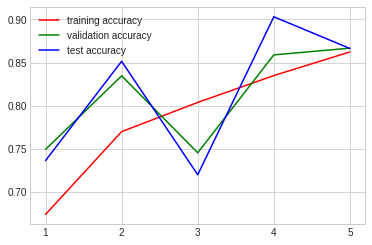

[0.67402523 0.76992546 0.80375573 0.83486239 0.86224197]
[0.74932651 0.83459052 0.74542026 0.8588362  0.8666487 ]
[0.73639548 0.85142781 0.71996228 0.90301724 0.86624461]


In [37]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

x = [1,2,3,4,5]
x = np.array(x)
train_a = np.array(train_a)
val_a = np.array(val_a)
test_a = np.array(test_a)

plt.xticks(np.linspace(0, 6, 6, endpoint=False))

plt.plot(x, train_a, color='red', label='training accuracy')
plt.plot(x, val_a, color='green', label='validation accuracy')
plt.plot(x, test_a, color='blue', label='test accuracy')
plt.legend()

plt.show()
print(train_a)
print(val_a)
print(test_a)

In [39]:
# For future analysis
# from sklearn.manifold import TSNE
# import numpy as np
# import matplotlib.pyplot as plt


# vector = TEXT.vocab.vectors[:1000,:]

# tsne = TSNE(n_components=2,init='pca',verbose=1)
# embedd = tsne.fit_transform(vector)

# plt.figure(figsize=(14,10))
# plt.scatter(embedd[50:1000,0], embedd[50:1000,1])
 
# for i in range(50, 1000):
#     x = embedd[i][0]
#     y = embedd[i][1]
#     plt.text(x, y, words[i])
# plt.show()


In [40]:
# print("index for the word absorbing: " + str(TEXT.vocab.itos.index('absorbing')))
# print("index for the word charming: " + str(TEXT.vocab.itos.index('charming')))
# print("index for the word the: " + str(TEXT.vocab.itos.index('the')))

# print("index for the word good: " + str(TEXT.vocab.itos.index('good')))
# print("index for the word excellent: " + str(TEXT.vocab.itos.index('excellent')))

# print("index for the word has: " + str(TEXT.vocab.itos.index('has')))
# print("index for the word had: " + str(TEXT.vocab.itos.index('had')))

In [41]:
# absorbing_vec = TEXT.vocab.vectors[1008]
# charming_vec = TEXT.vocab.vectors[370]
# the_vec = TEXT.vocab.vectors[2]
# good_vec = TEXT.vocab.vectors[55]
# excellent_vec = TEXT.vocab.vectors[596]
# has_vec = TEXT.vocab.vectors[29]
# had_vec = TEXT.vocab.vectors[207]

In [43]:
# print("Similarity between absorbing and charming: " + str(torch.dot(absorbing_vec, charming_vec.T)))
# print("Similarity between absorbing and good: " + str(torch.dot(absorbing_vec, good_vec.T)))
# print("Similarity between charming and the: " + str(torch.dot(charming_vec, the_vec.T)))

# print("Similarity between good and excellent: " + str(torch.dot(good_vec, excellent_vec.T)))

# print("Similarity between good and excellent: " + str(torch.dot(has_vec, had_vec.T)))